<a href="https://colab.research.google.com/github/juanpabloceruso/Food-Delivery-Analisis-de-Datos-con-Python/blob/main/Optimizaci%C3%B3n_de_Costos_de_Delivery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Delivery

## Introducción

Se cuenta con un dataset  de 1000 ordenes, que incluyen detalles de:


*   Order ID
*   Customer ID
*   Restaurant ID
*   Order and Delivery Date and Time
*   Order Value
*   Delivery Fee
*   Payment Method
*   Discounts and Offers
*   Comission Fee
*   Payment Processing Fee
*   Refunds/Chargebacks

Con esta información se puede analizar la estructura de costos y rentabilidad de la empresa de Delivery de Comidas.

## Objetivo

Una compañia se encuentra con el desafío de encontrar mayor rentabilidad dentro de sus operacion. Busca entender la dinámica la estructura de costos y rentabilidad, para indentificar oportunidades estratégicas de mejoras.

Los objetivos son:


1.   **Análisis Detallado de Costos**: Identifica los componentes más grandes del costo relacionado con el delivery de comida, identificando tanto costos directos como indirectos.
2.   **Evaluación de Rentabilidad**: Calcular la rentabilidad de ordenes individuales.
3.   **Recomendaciones Estratégicas para Mejoras**: Basado en los análisis de costos y rendimientos, identificar estrategias accionables para mejorar el rendimiento.
4.   **Simulación del Impacto de las Estrategias Propuestas**: Simular el impacto financiero de las estrategias recomendadas.




In [ ]:
import pandas as pd

food_orders = pd.read_csv("food_orders_new_delhi.csv")

food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [ ]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


Contamos con 12 columnas, y 1000 entradas, excepto en el caso de Discounts and Offers, columna que presenta NaN en los lugares donde no tubo descuentos. Reemplazamos dichos valores:

In [ ]:
food_orders.fillna({"Discounts and Offers":'None'}, inplace = True)

food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    1000 non-null   object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


Una vez que contamos con todo el dataset completo, iniciamos el proceso de limpieza de datos, para lo cual debemos realizar tres pasos:


*   Convertir Order Date and Time y Delivery Date and Time a formato Datetime.
*   Convertir Discounts and Offers a un formato numérico consistente o calcular los montos de descuentos.
*   Asegurar que todos los valores monetarios estén en un formato adecuado para calculos.



In [ ]:
from datetime import datetime

#Convertir las columnas de fecha y hora a Datetime
food_orders['Order Date and Time'] =  pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] =  pd.to_datetime(food_orders['Delivery Date and Time'])


In [ ]:
#Analizamos los valores únicos de esta columna
pd.unique(food_orders['Discounts and Offers'])

array(['5% on App', '10%', '15% New User', 'None', '50 off Promo'],
      dtype=object)

Vemos que cuando aparece un descuento puede decir off o %, si no aparece ninguno de estas dos cadenas de texto, implica que es 0 (None)

In [ ]:
#Primero creamos una función para extraer número del descuento
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

# Aplicamos la función para obtener un nuevo 'Discount Percentage'
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# Con estos porcentajes, calculamos el monto de descuento
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                              if x['Discount Percentage'] > 1
                                                              else x['Discount Percentage'], axis=1)

print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                 None                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

La información se encuentra lista con los siguientes ajustes:
*  Order Date and Time y Delivery Date and Time fueron convertidas a formato datetime.
*  Se añadió la columna Discount Amount, basada en los descuentos y ofertas.
*  Se añadió la columna Discount Percentage, basada en la columna original, extrayendo los valores numéricos.


## Análisis de Costos y Rendimientos

Para el análisis de costos se tomaran en cuenta los siguientes costos relacionados a cada orden:
*  **Delivery Fee**: Es el costo relacionado con el delivery de la orden.
*  **Payment Prcessing Fee**: Es el recargo relacionado con el procesamiento del pago.
*  **Discount Amount**: Es el monto de descuento provisto a la orden.

Se calculara el costo total para la plataforma, por cada orden, y luego calcular mediante la misma el costo total.

Por otro lado, para las ganancias de la plataforma tenemos el **Comission Fee**. Vamos a obtener el resultado neto, restando el costo total al comission Fee.

In [ ]:
# Calculamos el costo total y las ganancias por orden
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# Generamos agregaciones para obtener los valores totales
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 232709.85, 'Total Profit': -105719.85}


Basados en este análisis, estas son algunas de las métricas totales para la empresa de delivery de comida:
*  *Ordenes Totales*: 1000
*  *Ingresos Totales*:  126990
*  *Costos Totales*: 232709,85
*  *Resultado Total*: -105719,85

El análisis indica que los costos totales de la operación superan los ingresos generados, resultando en una pérdida neta. Lo cual sugiere que la actual política de comisiones, costos de envíos y descuentos no son sostenibles para generar resultados positivos.




Con el fin de comprender en mejor detalle la distribución de costos, ingresos y resultados, procedemos a graficar los mismos, dentro de los siguientes:
1. Un histograma de resultados por orden, para visualizar la distribución de ordenes rentables y no rentables.
2. Un gráfico de tartas para visualizar la distribución de los componentes del costo total.
3. Un gráfico de barras para comparar los totales de ingresos, costos y resultado.

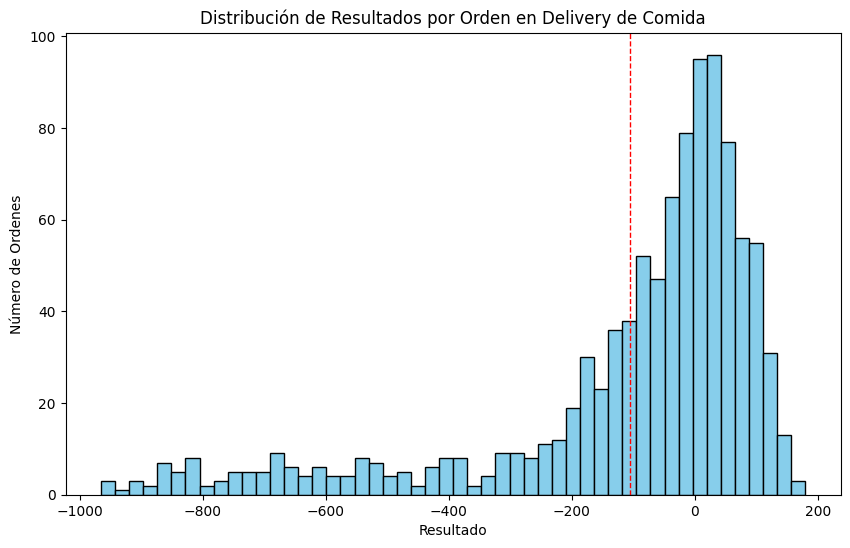

In [ ]:
import matplotlib.pyplot as plt

# Histograma de Rendimientos por Orden
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins = 50, color='skyblue', edgecolor='black')
plt.title('Distribución de Resultados por Orden en Delivery de Comida')
plt.xlabel('Resultado')
plt.ylabel('Número de Ordenes')
plt.axvline(food_orders['Profit'].mean(), color = 'red', linestyle = 'dashed', linewidth = 1)
plt.show()

Del histograma podemos ver el resultado por orden tiene una amplia distribución de valores, con una notable cantidad de ordenes resultando en pérdidas.
La línea roja nos indica el valor promedio, el cual es negativo, remarcando la situación actual de pérdidas para la empresa.

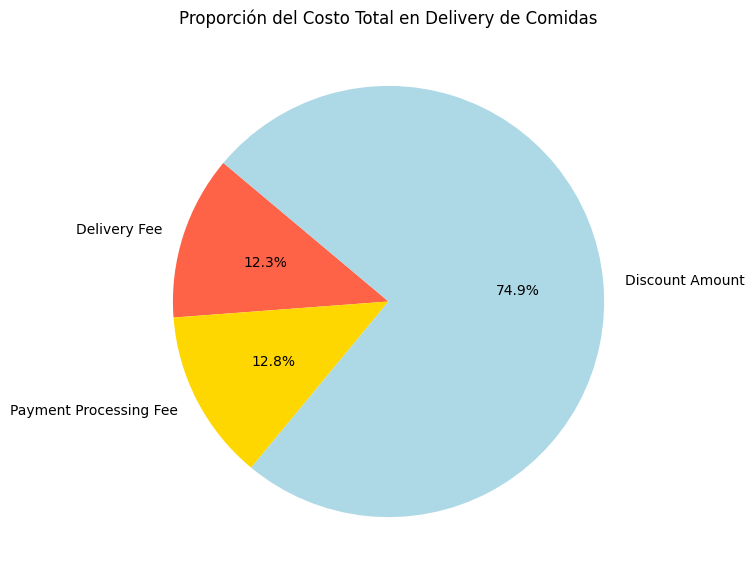

In [ ]:
# Gráfico de torta para las proporciones del costo total.
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7,7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proporción del Costo Total en Delivery de Comidas')
plt.show()

Del gráfico de totra se puede ver que el costo por descuentos representa una proporción elevada del costo total, lo cual puede indicar que las estrategias de promociones están impactando fuertemente en el resultado total.

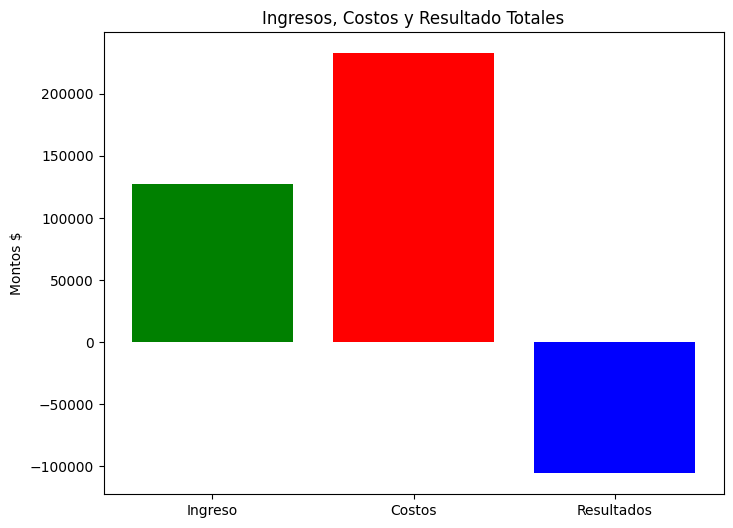

In [ ]:
# Gráfico de Barras de los totales de ingresos, costos y perdidas.
totals = ['Ingreso', 'Costos', 'Resultados']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8,6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Ingresos, Costos y Resultado Totales')
plt.ylabel('Montos $')
plt.show()

## Nueva Estrategia
Del análisis actual se puede comprender que los descuentos están resultando en una gran pérdida para la empresa. Por lo cual, se debe encontrar una nueva estrategia para lograr la rentabilidad.
Se debe encontrar un punto donde sean rentables las comisiones y los porcentajes de descuento. Para lograrlo, se puede analizar con mayor profundidad las características de las ordenes que fueron rentables.
Específicamente, podemos analizar lo siguiente:
1. El porcentaje medio de comisión basado sólo en las ordenes rentables.
2. El porcentaje medio de descuentos dentro de dichas ordenes.

Basandonos en estos valores medios, podríamos sugerir ajustes que podrían no sólo hacer que las ordenes individuales sean rentables, sino que aplicandolo a través de todas las ordenes, mejorarían el rendimiento global de la empresa.

In [ ]:
# Filtramos el conjunto de datos para obtener sólo las ordenes rentables:
profitable_orders = food_orders[food_orders['Profit'] > 0]

# Calculamos el valor medio de comisión para las mismas
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# Calculamos el valor medio de descuento para las mismas
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# Calculamos los valores medios globales para ordenes rentables
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

# Calculamos el valor medio de comisión para todas las ordenes
food_orders['Commission Percentage'] = (food_orders['Commission Fee'] / food_orders['Order Value']) * 100

# Calculamos el valor medio de descuento para todas las ordenes
food_orders['Effective Discount Percentage'] = (food_orders['Discount Amount'] / food_orders['Order Value']) * 100

# Calculamos los valores medios globales para todas las ordenes
new_avg_commission_percentage_all = food_orders['Commission Percentage'].mean()
new_avg_discount_percentage_all = food_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage,new_avg_commission_percentage_all, new_avg_discount_percentage, new_avg_discount_percentage_all)

Basado en este análisis de ordenes rentables, encontramos un nuevo conjunto de valores medios que pueden representar el "Punto Ideal" para comisión y descuento:
*  Porcentaje de Comisión Media = 30,51% (vs 19,75%)
*  Porcentaje de Descuento Medio = 5,87% (vs 16,26%)

El porcentaje de comisión par las ordenes rentables es significativamente mayor que el valor global. Lo cual sugiere que una comisión mayor puede ser clabe para un mejor resultado.
Por otro lado, el valor medio de descuento es significativamente menor para las ordenes rentbales, indicando que que un descuento menor puede contribuir al mejor resultado, sin deteriorar significativamente el volumen de compras.

Basados en este análisis, una estrategia que apunte a lograr una comisión cercana a 30% y un descuento cercano al 6% podría potencialmente mejorar el rendimiento.

Ahora, visualicemos la comparación del rendimiento actual versus el rendimiento con los descuentos recomendados. Para esto, debemos:
1. Calcular el rendimiento por orden usando los valores actuales de descuentos y comisiones.
2. Simular el rendimiento por orden usando los valores recomendadode descuentos y comisiones, para ver el impacto potencial.
Esta comparación nos permitirá ilustrar el potencial impacto de adoptar los cambios propuestos.


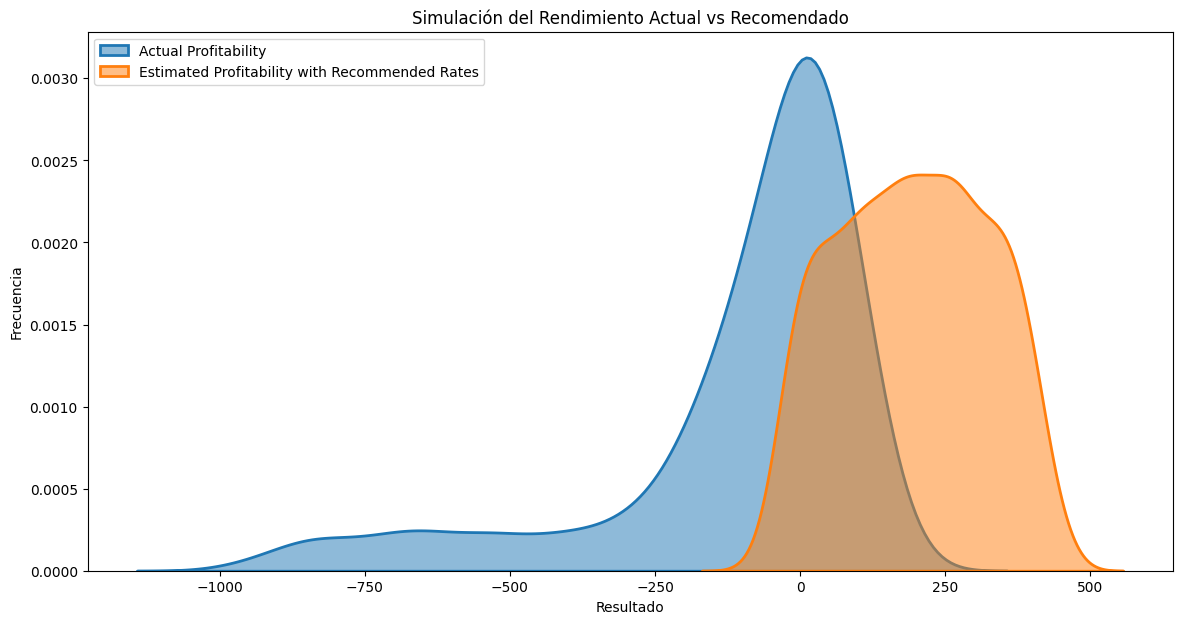

In [ ]:
#Simular el rendimiento con los descuentos y comisiones recomendadas
recommended_commission_percentage = 30.0  # 30%
recommended_discount_percentage = 6.0    # 6%


# Calcular la comisión y descuento simulados a partir de estos valores
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# Recalcular el ingreso y el costo total
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

# Visualizar la comparación
import seaborn as sns

plt.figure(figsize=(14, 7))

# Rendimiento Actual
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# Simulación del Rendimiento
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Simulación del Rendimiento Actual vs Recomendado')
plt.xlabel('Resultado')
plt.ylabel('Frecuencia')
plt.legend(loc='upper left')
plt.show()

Esta visualización compara la distribución de resultado por orden, usando los valores actuales contra los valores recomendados de un descuento del 6% y una comisión del 30%.

Podemos ver que a diferencia de la distribución actual, la simulada sugiere un escenario con una mayor rentabilidad. La distribución está casi completamente en el eje positivo, por lo que se puede concluir que la recomendación generaría una mayor proporción de ordenes rentables.